In [4]:
#!/usr/bin/env python

#DBR last updated 07/2019
#This code runs the global sensitivity analysis and outputs a csv for downstream analysis
#it can take a really long time to run (like 12 hours)

%matplotlib inline  

#ipython magic to make ampmodule autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st 
import sklearn.linear_model as slm 
from pyDOE import *
#from numba import autojit #for paralellization

#pull in the classes to do the sims!
import AMPmodule

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#labels etc for plots
trialcolz=['teal','tan']

short_outz_labels=['PE','mean VL1','std dev VL1','mean IC50','std dev IC50']
long_outz_labels=['prevention efficacy (%)',
                  'mean VL1 log10(copies/mL)',
                  'std dev VL1 log10(copies/mL)',
                  'mean IC50 log10($\mu$g/mL)',
                  'std dev IC50 log10($\mu$g/mL)']

short_varz_labels=[r'$\log_{10}\phi$',r'$f$',r'$\log_{10}x_{50}$',r'$A_0$']
long_varz_labels=[r'potency reduction factor, $\log_{10}\phi$',
                  r'resistant fraction, $f$',
                  r'maximum IC50 $\log_{10}x_{50}$',
                  r'initial number infected cells $A_0$']

#standardize limits/ticks
ytickz=[[0,0.25,0.5,0.75,1],
       [0,1,2,3,4,5,6,7],
       [1,2,3],
       [-1,0,1,2],
       [0,1,2]]

xtickz=[[0,1,2,3],
       [0,0.2,0.4,0.6,0.8,1],
       [2,3,4],
       [0,5,10,15,20]]

In [5]:
#function to analyze output from a trial simultaion
def analyze_out(trial_list,tr_ctl):
    nts=len(trial_list)
    PE=np.zeros([nts])
    fpvls_avg=np.zeros([nts]); fpvls_std=np.zeros([nts]);
    IC50s_avg=np.zeros([nts]); IC50s_std=np.zeros([nts]);

    for it in range(nts):
        tr=trial_list[it]
        fpvls=np.log10(tr.fp_vs[tr.fp_vs>0])
        fpis=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2 #first positive indicies
        fpts=tr.fp_ts[tr.fp_vs>0]

        #rescale the IC50 so it matches what will be measured in vitro
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #now trial summary outcomes
        PE[it]=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)

        fpvls_avg[it]=np.nanmean(fpvls)
        fpvls_std[it]=np.nanstd(fpvls)

        IC50s_avg[it]=np.nanmean(IC50s)
        IC50s_std[it]=np.nanstd(IC50s)

    outcomes=np.array([PE,fpvls_avg,fpvls_std,IC50s_avg,IC50s_std])

    return outcomes

In [6]:
#now do global sensitivity analyses!
D=[10,30]

nts=100 #number of trials
Nps=100 #number of exposures per trial

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%
mx=50+np.logspace(0,4,nts) #maximum IC50
A0=np.round(np.linspace(1,20,nts)) #initial number of infected cells -- will repeat a bit if nts>20

varz=np.array([iv,rf,mx,A0]) #make array of variable values
lhvarz=lhs(len(varz), samples=nts).T*varz #latin hypercube samples
pltvarz=np.array([np.log10(lhvarz[0,:]),lhvarz[1,:],np.log10(lhvarz[2,:]),np.round(lhvarz[3,:])]) #make array of variable values

%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

# should take parallel ~nts**2 * cpu_times / num_cores
# should take normal nts*2*cpu_times?

# Define the function. Each remote function will be executed in a separate process.
def run_global(D,iid,Nps,varz,iit):
    g_out = AMPmodule.trial(name='D_'+str(D[iid])+'_'+str(iit), nps=Nps, tF=560, 
                           dose=D[iid], clade='bimodal', 
                           rfrac=varz[1,iit], A0=varz[3,iit], iv_phi=varz[0,iit], maxIC50=varz[2,iit], 
                               v_flg=False, keep_flg=0)
    return g_out


CPU times: user 53.4 s, sys: 288 ms, total: 53.7 s
Wall time: 53.5 s


In [7]:
#can I make this parallel?

list_tr_global=[[],[]];
for iit in range(nts):
    for iid in range(len(D)):
        list_tr_global[iid].append(run_global(D,iid,Nps,lhvarz,iit))
        #list_tr_global[iid].append(run_global.remote(D,iid,counter,Nps,lhvarz,iit))
        
        
    print(iit)
#print('done')
#lg = ray.get(list_tr_global)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [8]:
#make the total sensitivity analysis data frame
v_df=pd.DataFrame(pltvarz.T,columns=['log10phi','f_r','log10x_50','A0'])

sa_df=pd.DataFrame() #sensitivity analysis df
for iid in range(len(D)):
    g_out=analyze_out(list_tr_global[iid],tr_ctl) #analyze trial sims and calculate outputs
    o_df = pd.DataFrame(g_out.T,columns=['PE','fpvls_avg','fpvls_std','IC50s_avg','IC50s_std']) #output df
    d_df = pd.DataFrame(np.ones([nts])*D[iid],columns=['dose']) #dose df
    sa_df=sa_df.append(pd.concat([v_df,o_df,d_df], axis=1))

pd.DataFrame.to_csv(sa_df,'data/sa_df.csv') #print the csv for later analysis

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [10]:
#density plot of breakthrough IC50s
for v in range(len(short_varz_labels)):
    plt.figure(figsize=(12,5))
    for iit in range(nts):    
        #for iid in range(len(D)):
        tr=list_tr_global[iid][iit]
        #rescale the IC50 so it matches what will be measured in vitro
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        if IC50s.size:
            plt.violinplot(IC50s,positions=[pltvarz[v][iit]],widths=max(pltvarz[v])/nts*2)
    plt.ylabel('breakthrough IC50 log10($\mu$g/mL)',fontsize=14)
    plt.xlabel(long_varz_labels[v],fontsize=14)
    plt.savefig('figures/global/violinIC50_'+str(v)+'.pdf',dpi=600)
plt.close('all')

In [11]:
#density plot of breakthrough IC50s
for v in range(len(short_varz_labels)):
    plt.figure(figsize=(6,10))
    inds=np.argsort(pltvarz[v])
    pind=0
    pindfac=5
    yt=len(inds)/pindfac
    for iit in inds:    
        for iid in range(len(D)):
            tr=list_tr_global[iid][iit]
            #rescale the IC50 so it matches what will be measured in vitro
            IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
            IC50s[IC50s>np.log10(50)]=np.log10(50)

            #plt.violinplot(IC50s,positions=[rf[it]],widths=0.1)
            hh=np.histogram(IC50s,bins=10)
            plt.fill_between(hh[1][1:],hh[0]/max(hh[0])+pind/pindfac,
                             np.ones(len(hh[1][1:]))*pind/pindfac,lw=2,alpha=0.5,color=trialcolz[iid])

            plt.ylim([-1,len(inds)/pindfac+1])

            pind+=1/2
    plt.xlabel('breakthrough IC50 log10($\mu$g/mL)',fontsize=14)
    plt.ylabel(long_varz_labels[v],fontsize=14)
    #plt.ylabel('fraction resistant (IC50>50$\mu$g/mL), $f$',fontsize=14)
    plt.yticks([0,yt/4,yt/2,yt*3/4,yt],[0,1/4,1/2,3/4,1])
    #plt.savefig('figures/gsense_density-rf.pdf',dpi=600)
    plt.savefig('figures/global/densityIC50_'+str(v)+'.pdf',dpi=600)
plt.close('all')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


exposure week: [78. 17.  5. 58. 67. 10. 66. 73. 31. 79.]
exposure interval (1st or 2nd): [2. 1. 2. 1. 1. 1. 1. 1. 2. 2.]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


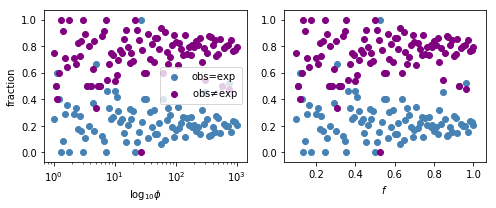

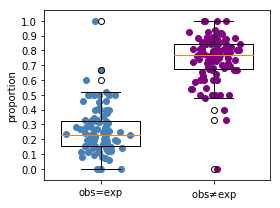

In [15]:
#show how much the delay effect varies across global sensitivity analysis?

#have to figure out if detected interval represents real exposure interval

#check the calculation
print('exposure week:',np.floor(tr_ctl.ex_ts[:10]/7))
print('exposure interval (1st or 2nd):',1+np.floor(tr_ctl.ex_ts[:10]/7/4)%2)

#make the matrix of exposures > detections
def calc_brksmat(tr):
    exts=1+np.floor(tr.ex_ts[tr.fp_ts>0]/7/4)%2
    fpts=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2
    brksmat=np.zeros([2,2])
    for i in range(len(exts)):    
        if exts[i]==1 and fpts[i]==1:
            brksmat[0,0]+=1 #exp 1, det 1
        if exts[i]==1 and fpts[i]==2:
            brksmat[0,1]+=1 #exp 1, det 2
        if exts[i]==2 and fpts[i]==1:
            brksmat[1,0]+=1 #exp 2, det next 1
        if exts[i]==2 and fpts[i]==2:
            brksmat[1,1]+=1 #exp 2, det 2

    return brksmat

#calculate for all trials
obstrue=np.zeros([nts])
obsfalse=np.zeros([nts])
for iit in inds:    
    #for iid in range(len(D)):
    tr=list_tr_global[iid][iit]
    brksmat=calc_brksmat(tr)
    obstrue[iit]=(brksmat[0,0]+brksmat[1,1])/np.sum(brksmat)
    obsfalse[iit]=(brksmat[0,1]+brksmat[1,0])/np.sum(brksmat)
    
goodind=~np.isnan(obstrue)
obstrue=obstrue[goodind]
obsfalse=obsfalse[goodind]

plt.figure(figsize=(7,3))

plt.subplot(121)
plt.scatter(iv[goodind],obstrue,color='steelblue')
plt.scatter(iv[goodind],obsfalse,color='purple')
plt.semilogx()
plt.xlabel(short_varz_labels[0])
plt.ylabel('fraction')
plt.legend(['obs=exp',r'obs$\ne$exp'])

plt.subplot(122)
plt.scatter(rf[goodind],obstrue,color='steelblue')
plt.scatter(rf[goodind],obsfalse,color='purple')
plt.xlabel(short_varz_labels[1])

plt.tight_layout()
plt.savefig('figures/gsense_delays1.pdf',dpi=600)

#visualize another way
plt.figure(figsize=(4,3))
plt.boxplot([obstrue,obsfalse],positions=[1,2],widths=0.7)#,color='k')
plt.scatter(np.random.normal(1,0.1,len(obstrue)),obstrue,color='steelblue')
plt.scatter(np.random.normal(2,0.1,len(obsfalse)),obsfalse,color='purple')
#plt.grid()
plt.xticks([1,2],['obs=exp',r'obs$\ne$exp'])
plt.ylabel('proportion')# across 100 \n global sensitivity analyses')
plt.yticks(np.linspace(0,1,11))
plt.ylim()
plt.tight_layout()

plt.savefig('figures/gsense_delays2.pdf',dpi=600)
